In [9]:
import sys
sys.path.append('../../../../src')
import os
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from data.datamodule import SHOWDataModule
from models.gcn_model import NodeEncodedGCN, NodeEncodedGCN_tt, NodeEncodedGCN_1l, NodeEncodedGCN_2l, NodeEncodedGCN_3l


def simple_model_evaluation(y_test, y_pred_test):
    # Simple model evaluation that computes and prints MSE, RMSE and MAPE for the training and testing set

    # train_error_mse = np.square(y_train - y_pred_train).sum() / y_train.shape[0]
    test_error_mse = np.square(y_test - y_pred_test).sum() / y_test.shape[0]

    # train_error_mape = (100 / y_train.shape[0]) * (
    #    np.absolute(y_train - y_pred_train) / y_train
    # ).sum()  # y_train should never be 0 since the travel time in a segment cannot be 0
    test_error_mape = (100 / y_test.shape[0]) * (np.absolute(y_test - y_pred_test) / y_test).sum()

    test_error_mae = (1 / y_test.shape[0]) * (np.absolute(y_test - y_pred_test)).sum()
    print("-----------MSE----------")
    # print("Training error: {}".format(train_error_mse))
    print("Testing error: {}".format(test_error_mse))
    print("-----------RMSE----------")
    # print("Training error: {}".format(np.sqrt(train_error_mse)))
    print("Testing error: {}".format(np.sqrt(test_error_mse)))
    print("-----------MAPE----------")
    # print("Training error: {:.2f} %".format(train_error_mape))
    print("Testing error: {:.2f} %".format(test_error_mape))
    print("-----------MAE----------")
    print("Testing error: {}".format(test_error_mae))
    return test_error_mse, np.sqrt(test_error_mse), test_error_mape, test_error_mae



In [10]:
# Path for the checkpoint directory
checkpoint_dir = '.'
model_names = os.listdir(checkpoint_dir)

# remove all files not ending on ckpt
model_names = [model_name for model_name in model_names if model_name.endswith('ckpt')]


In [11]:
model_names

['ne_gcn-6730-07271316.ckpt',
 'ne_gcn-9070-07271316.ckpt',
 'ne_gcn-6278-07271316.ckpt',
 'ne_gcn-4231-07271316.ckpt']

In [12]:

# Load the datamodule
site_name = 'GRAZ'
transform = 'maxmin'
batch_size = 64
empty_graph = False
time_kind = 'travel_times'
data_module = SHOWDataModule(
    site_name=site_name,
    transform=transform,
    num_lags=2,
    train_frac=0.9,
    batch_size=batch_size,
    empty_graph=empty_graph,
    verbose=False,
    time_kind=time_kind,
)
transform = data_module.setup()


In [13]:

# Load the models and evaluate them
results = []
for model_name in model_names:
    print(model_name)

    # Load model checkpoint
    checkpoint_dict = torch.load(model_name)
    model = NodeEncodedGCN_1l(
        transform=checkpoint_dict['hyper_parameters']['transform'],
        weight_decay=checkpoint_dict['hyper_parameters']['weight_decay'],
        lr=checkpoint_dict['hyper_parameters']['lr'],
        drop_p=checkpoint_dict['hyper_parameters']['drop_p'],
        batch_size=checkpoint_dict['hyper_parameters']['batch_size'],
        input_size=checkpoint_dict['hyper_parameters']['input_size'],
        hidden_layers=checkpoint_dict['hyper_parameters']['hidden_layers'],
        aggregation_function=checkpoint_dict['hyper_parameters']['aggregation_function'],
    )
    model = model.load_from_checkpoint(f'{model_name}')

    trainer = pl.Trainer(gpus=1)
    results.append(trainer.test(model, datamodule=data_module, verbose=False))

# Print the results
mse_arr = np.array([run_dict[0]['test/error_mse'] for run_dict in results])
mae_arr = np.array([run_dict[0]['test/error_mae'] for run_dict in results])
mape_arr = np.array([run_dict[0]['test/error_mape'] for run_dict in results])
rmse_arr = np.array([run_dict[0]['test/error_rmse'] for run_dict in results])

ne_gcn-6730-07271316.ckpt


/home/manity/SHOW_folder/ETA-prediction-autonomous-shuttles/envs/test_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/manity/SHOW_folder/ETA-prediction-autonomous-shuttles/envs/test_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` pac

Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]-----------MSE----------
Testing error: 306.3897399902344
-----------RMSE----------
Testing error: 17.503992080688477
-----------MAPE----------
Testing error: 10.07 %
-----------MAE----------
Testing error: 13.412203788757324
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



ne_gcn-9070-07271316.ckpt
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 145.11it/s]-----------MSE----------
Testing error: 312.5423889160156
-----------RMSE----------
Testing error: 17.678869247436523
-----------MAPE----------
Testing error: 10.33 %
-----------MAE----------
Testing error: 13.684033393859863
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 73.17it/s] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


ne_gcn-6278-07271316.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 123.33it/s]-----------MSE----------
Testing error: 394.9065246582031
-----------RMSE----------
Testing error: 19.872255325317383
-----------MAPE----------
Testing error: 11.20 %
-----------MAE----------
Testing error: 14.939044952392578
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 60.97it/s] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


ne_gcn-4231-07271316.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 104.34it/s]-----------MSE----------
Testing error: 362.2132873535156
-----------RMSE----------
Testing error: 19.031902313232422
-----------MAPE----------
Testing error: 10.97 %
-----------MAE----------
Testing error: 14.335135459899902
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 52.84it/s] 


In [14]:
print(f'Results for {site_name} with {type(transform)} transform and {time_kind} time kind')
print(f'MSE: {mse_arr.mean()} +/- {mse_arr.std()}')
print(f'MAE: {mae_arr.mean()} +/- {mae_arr.std()}')
print(f'RMSE: {rmse_arr.mean()} +/- {rmse_arr.std()}')

Results for GRAZ with <class 'data.datamodule.MaxMin'> transform and travel_times time kind
MSE: 344.0129852294922 +/- 36.494213129092905
MAE: 14.092604398727417 +/- 0.5926968412663832
RMSE: 18.5217547416687 +/- 0.9785702787332601


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/manity/SHOW_folder/ETA-prediction-autonomous-shuttles/envs/test_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

ne_gcn-6730-07271316.ckpt
Predicting: 0it [00:00, ?it/s]

Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 26.37it/s] 


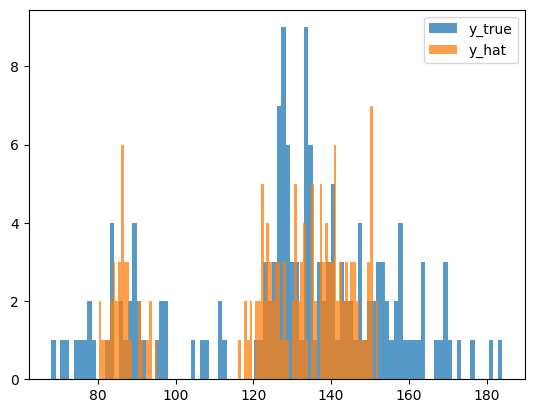

In [15]:
best_model = model_names[np.argmin(mse_arr)]

print(best_model)

# Load model checkpoint
checkpoint_dict = torch.load(best_model)
model = NodeEncodedGCN_1l(
    transform=checkpoint_dict['hyper_parameters']['transform'],
    weight_decay=checkpoint_dict['hyper_parameters']['weight_decay'],
    lr=checkpoint_dict['hyper_parameters']['lr'],
    drop_p=checkpoint_dict['hyper_parameters']['drop_p'],
    batch_size=checkpoint_dict['hyper_parameters']['batch_size'],
    input_size=checkpoint_dict['hyper_parameters']['input_size'],
    hidden_layers=checkpoint_dict['hyper_parameters']['hidden_layers'],
    aggregation_function=checkpoint_dict['hyper_parameters']['aggregation_function'],
)
model = model.load_from_checkpoint(f'{best_model}')

trainer = pl.Trainer(gpus=1)

output = trainer.predict(model, dataloaders=data_module.test_dataloader())
y_hat = np.concatenate([out[0] for out in output])
y_true = np.concatenate([out[1] for out in output])

df = pd.DataFrame({'y_true': y_true, 'y_hat': y_hat})
df.to_csv(f'{best_model}_pred.csv', index=False)

fig, ax = plt.subplots()
ax.hist(y_true, bins=100, alpha=0.75)
ax.hist(y_hat, bins=100, alpha=0.75)
ax.legend(['y_true', 'y_hat'])